# Chest X-Ray Medical Diagnosis with Deep Learning

## Table of Contents

- [1. Import Packages](#1)
- [2. Load the Datasets](#2)
    - [2.1 Loading the Data](#2-1)
    - [2.2 Preventing Data Leakage](#2-2)
        - [Check for leakage](#check)
    - [2.3 Preparing Images](#2-3)
- [3. Model Development](#3)
    - [3.1 Addressing Class Imbalance](#3-1)
    - [3.2 DenseNet121](#3-2)
- [4. Training](#4)
- [5. Prediction and Evaluation](#5)
    - [5.1 ROC Curve and AUROC](#5-1)

<a name='1'></a>
## 1. Import Packages

In [47]:
#import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

<a name='2'></a>
## 2. Load the Datasets

We will use the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315). This dataset contains 108,948 frontal-view X-ray images of 32,717 unique patients.
- Each image in the datset contains multiple text-mined labels identifying 14 different pathological conditions.
- These can be used by physicians to diagnose 8 different diseases.
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies.
- It will predict 'positive' or 'negative' for each of the pathologies.

The entire dataset can be downloaded [here](https://nihcc.app.box.com/v/ChestXray-NIHCC).
- For now we will use ~1000 image subset

The dataset includes a CSV file that provides the labels for each X-ray. 
Here, we have three csv files:

1. `nih/train-small.csv`: 875 images from our dataset to be used for training.
2. `nih/valid-small.csv`: 109 images from our dataset to be used for validation.
3. `nih/test.csv`: 420 images from our dataset to be used for testing.

<a name='2-1'></a>
### 2.1 Loading the Data

In [2]:
train_df = pd.read_csv("data/nih/train-small.csv")
valid_df = pd.read_csv("data/nih/valid-small.csv")

test_df = pd.read_csv("data/nih/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [3]:
labels = ['Cardiomegaly','Emphysema', 'Effusion', 'Hernia', 'Infiltration',
         'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
         'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

<a name='2-2'></a>
### 2.2 Preventing Data Leakage
Our dataset contains multiple images for each patient. A patient could have taken multiple X-ray images at different times during their hospital visits. The data split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

<a name='check'></a>
### Check for leakage
We will write a function to check whether there is a leakage between two datasets. We will use this to make sure there are no patients in the test set that are also present in either the train or validation sets. 

In [4]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there are any patients that are in both df1 and df2.
    
    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
        
    Returns:
        leakage (bool): True if there is leakage, otherwise False
        """
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    
    #leakage contains True if there is patient overlap, otherwise False
    leakage = len(patients_in_both_groups)>0 # boolean (true if there is at least 1 patient in both groups)
    
    return leakage

In [5]:
#some test cases for the function
# test_df1 = pd.DataFrame([0,1,2], columns=['patient_id'])
# test_df2 = pd.DataFrame([2,3,4], columns=['patient_id'])
# check_for_leakage(test_df1, test_df2, 'patient_id')

# test_df1 = pd.DataFrame([0,1,2], columns=['patient_id'])
# test_df2 = pd.DataFrame([3,4,5], columns=['patient_id'])
# check_for_leakage(test_df1, test_df2, 'patient_id')

In [6]:
print(f"leakage between train and valid: {check_for_leakage(train_df, valid_df, 'PatientId')}")
print(f"leakage between train and test: {check_for_leakage(train_df, test_df, 'PatientId')}")
print(f"leakage between valid and test: {check_for_leakage(valid_df, test_df, 'PatientId')}")

leakage between train and valid: True
leakage between train and test: False
leakage between valid and test: False


<a name='2-3'></a>
### 2.3 Preparing Images

- We will use [ImageDataGenerator](https://keras.io/preprocessing/image/) class from Keras, which allows us to build a "generator" for images specified in a dataframe.
- We will also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1. This helps in training the model by standardizing the input distribution.
- The genrator also converts our single channel X-ray image(gray-scale) to a three-channel format by repeating the values in the image across all channels. This is required because the model that we will use requires three channel-inputs.
- We do the following things:
    1. Normalize the mean and standard deviation of the data
    2. Shuffle the input after each epoch
    3. Set the image size to be 320px by 320px

In [7]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w=320, target_h=320):
    """
    Return generator for training set, normalizing using batch statistics.
    
    Args:
        train_df (dataframe): dataframe specifying training data.
        image_dir (str): directory where image files are held.
        x_col (str): name of column in df that holds filenames.
        y_cols (list): list of tsrings that hold y labels for images.
        batch_size(int): images per batch to be fed into model during training.
        seed (int): random seed.
        target_w (int): final width of input images.
        target_h (int): final height of input images.
        
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """
    
    print("getting train generator...")
    ##normalize images
    image_generator = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
    
    # flow from directory with specified batch size and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w, target_h))
    
    return generator

#### Build a separate generator for valid and test sets

We need to build a new generator for validation and test data.

We cannot use the same generator as for the training data. This is beacuse the generator for training data normalizes each image per batch, i.e. it uses batch statistics. In real life scenario we don't process incoming images a batch at a time (we process one image at a time).

We will normalize the incoming test data using the statistics computed from the training set.

In [8]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting test and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [9]:
IMAGE_DIR = "data/nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting test and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


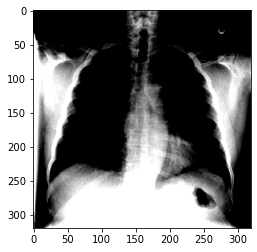

In [10]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

<a name='3'></a>
## 3. Model Development

<a name='3-1'></a>
### 3.1 Addressing Class Imbalance

In medical datasets generally there are large class imbalance. Let's plot the frequency of each labels in our dataset.

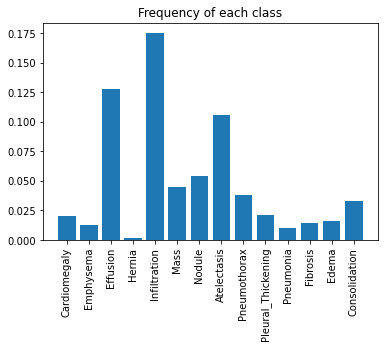

In [11]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of each class")
plt.show()

From the plot, we can see that the prevalance of positive class is very less. This will be problematic if we use the regular cross-entropy loss for each pathology. the loss will be dominated by negative class which has higher frequency.

<a name ='3-1-1'></a>
### 3.1.1 Computing Class Frequencies

In [12]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequencies for each class
    
    Args:
        label (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequencies for each class, size (num_classes)
        negative_frequencies (np.array): array of negative frequencies for each class, size (num_classes) 
    """
    N = labels.shape[0] #total number of patients (rows)
    
    positive_frequencies = labels.sum(axis=0)/N
    negative_frequencies = 1-positive_frequencies
    
    return positive_frequencies, negative_frequencies

In [13]:
# test_label = np.array([[1,0,0],[0,1,1],[1,0,1],[1,1,1],[1,0,1]])
# compute_class_freqs(test_label)

In [14]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

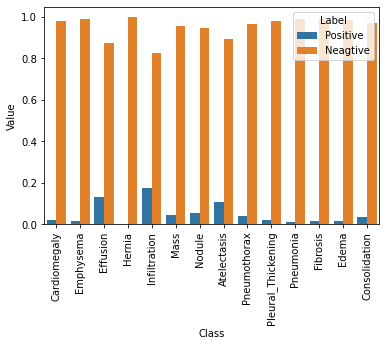

In [15]:
data = pd.DataFrame({"Class":labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label":"Neagtive","Value":v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f= sns.barplot(x="Class", y="Value", hue="Label", data=data)

The contribution of positive cases is significantly lower than negative cases. We want the contribution to be equal. One way to do this is to multiply positive frequencies with weight=negative_frequencies and multiply negative frequencies with weight=positive_frequenices.

In [16]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights 

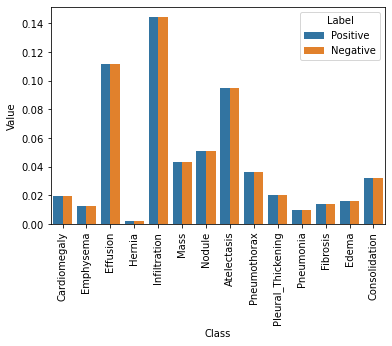

In [17]:
data = pd.DataFrame({"Class": labels, "Label":"Positive", "Value":pos_contribution})
data = data.append([{"Class": labels[l], "Label":"Negative", "Value":v} for l,v in enumerate(neg_contribution)],
                  ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)

With this positive and negative classes will have the same contribution. While calculating the loss function, we need to multiply the loss with these weights.

<a name='3-1-2'></a>
### 3.1.2 Get Weighted Loss

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [18]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -(K.mean(pos_weights*y_true*K.log(y_pred+epsilon)) + K.mean(neg_weights*(1-y_true)*K.log(1-y_pred+epsilon))) #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

<a name='3-2'></a>
### 3.2 DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [24]:
# create the base pretrained model
base_model = DenseNet121(weights='models/nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss= get_weighted_loss(pos_weights, neg_weights))

<a name='4'></a>
### 4. Training

In [29]:
history = model.fit_generator(train_generator,
                             validation_data=valid_generator,
                             steps_per_epoch=100,
                             validation_steps=25,
                             epochs=3)

Epoch 1/3
100/100 [==============================] - 1907s 19s/step - loss: 0.9205 - val_loss: 13.0960
Epoch 2/3
100/100 [==============================] - 1796s 18s/step - loss: 0.9156 - val_loss: 1.2802
Epoch 3/3
100/100 [==============================] - 1772s 18s/step - loss: 0.8594 - val_loss: 9.0550


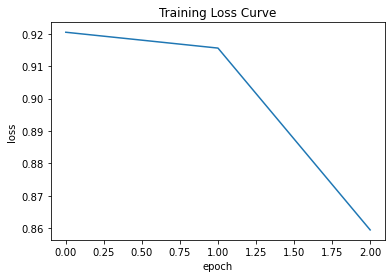

In [35]:
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

We have trained on a small subset of the dataset (~1%). 
We will use pre-trained weights into the model.

In [37]:
model.load_weights("models/nih/pretrained_model.h5")

<a name='5'></a>
### 5. Prediction and Evaluation

In [39]:
predicted_vals = model.predict_generator(test_generator, steps=len(test_generator))

In [45]:
predicted_vals.shape

(420, 14)

<a name='5-1'></a>
### 5.1 ROC Curve and AUROC

In [52]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        gt = generator.labels[:,i]
        pred = predicted_vals[:, i]
        auc_roc = roc_auc_score(gt, pred)
        auc_roc_vals.append(auc_roc)
        fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
        plt.figure(1, figsize=(10,10))
        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr_rf, tpr_rf,
                label = labels[i]+" ("+ str(round(auc_roc, 3))+")")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title("ROC curve")
        plt.legend(loc="best")
    plt.show()
    return auc_roc_vals
        

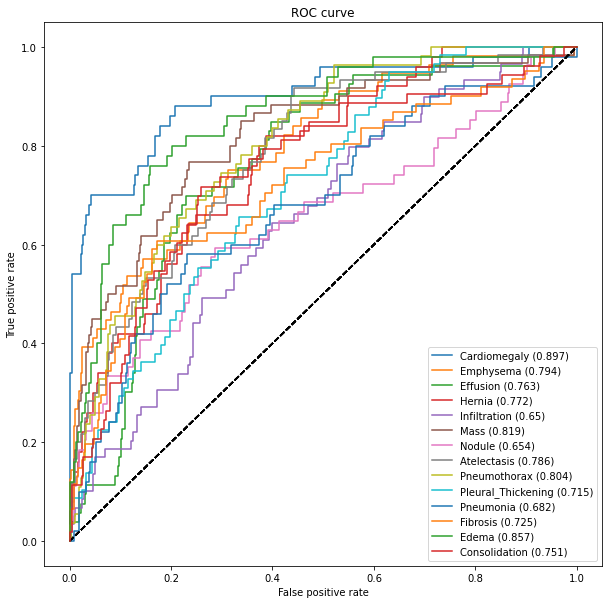

In [53]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)